* https://plot.ly/python/maps/
* https://data.sfgov.org/Economy-and-Community/Mobile-Food-Facility-Permit/rqzj-sfat

To do:

* Create map
* Write-up

Food cart history:

* https://www.history.com/news/from-chuck-wagons-to-pushcarts-the-history-of-the-food-truck
* https://mobile-cuisine.com/business/history-of-american-food-trucks/

From timeless classics like the House of Prime Rib to bizarre fusions like Sushirrito, San Francisco (SF) is know for its diverse food scene. But roaming up and down the crowded streets of SF are hundreds of mobile food facilities. These fast, casual faux resturants can be found on street corners selling mysterious meat wrapped in bacon or sprawled as far as the eye can see at their own festival. 

A mobile food facility must be permitted by the the City of San Francisco to legally sell food. The city of San Francisco publishes partial information of permit applications on their website. This dataset is taken from the San Francisco Department of Public Works. 

Two types of mobile food facilities are recognized in the dataset: push carts and food trucks. The history of each is rather fascinating. In 1691 New Amsterdam, now known as New York City, began to regulate push carts selling food (2). The tradition of push carts serving lunches to city workers continues to this day. Eventually the push cart gave way to food trucks in the 1960s, the ice cream trucks were the first to appear in the 1950s (1). These early adopters were given the derogatory name of "roach coaches" due to the often sub-standard health conditions and the less than ideal areas they set up shop (1). But, by the late 1990s and early 2000s attitudes towards food trucks had shifted and customers, and the food service industry as a whole, had wholeheartedly embraced these food serving trucks. Indeed, it's not uncommon to find whole areas of citys allotted to food trucks or find blogs devoted solely to finding the next hit truck.

From this data we will create a interactive map of the location all the permitted food facilites in SF. [While there are websites that allow food trucks to update their location, many food push carts do not utilize this tool.]


<img src="images\push.jpg" width="30%">
A typical push cart selling a variety of hot foods and cold beverages


<img src="images\truck.jpg" width="80%">

In [18]:
import plotly.plotly as py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test

In [3]:
pd.set_option('display.max_columns', None)
plt.rc('figure', figsize=(8,8))
sns.set_style('darkgrid')

# Importing Data

Get a sense of the data.

In [4]:
sf = pd.read_csv('data/Mobile_Food_Facility_Permit.csv')
sf.shape

(632, 24)

Looking at the first couple rows of the data most of the columns are not necessary. The administrative columns, like NOISent, and non-geographic coordinate location data, like Address and lot, can be dropped to save memory.
We'll focus on the Applicant, Latitude, Longitude and Fooditems in this analysis.

In [5]:
sf.head(3)

,locationid,Applicant,FacilityType,cnn,LocationDescription,Address,blocklot,block,lot,permit,Status,FoodItems,X,Y,Latitude,Longitude,Schedule,dayshours,NOISent,Approved,Received,PriorPermit,ExpirationDate,Location
0,1152244,San Francisco's Hometown Creamery,Truck,6109000,GEARY ST: STOCKTON ST to POWELL ST (200 - 299),281 GEARY ST,0314013,0314,013,17MFF-0001,APPROVED,Ice cream,6010423.418,2114694.802,37.787136,-122.407719,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Su:11AM-11PM;Fr/Sa:6PM-11PM,NaN,10/16/2018 12:00:00 AM,2017-01-09,0,07/15/2019 12:00:00 AM,"(37.7871364910861, -122.407718509001)"
1,751253,Pipo's Grill,Truck,5688000,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,3549083,3549,083,16MFF-0010,REQUESTED,Tacos: Burritos: Hot Dogs: and Hamburgers,6007856.719,2107724.046,37.767852,-122.416105,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2016-02-04,0,NaN,"(37.7678524427181, -122.416104892532)"
2,735318,Ziaurehman Amini,Push Cart,30727000,MARKET ST: DRUMM ST intersection,5 THE EMBARCADERO,0234017,0234,017,15MFF-0159,REQUESTED,NaN,6013916.720,2117244.027,37.794331,-122.395811,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2015-12-31,0,03/15/2016 12:00:00 AM,"(37.7943310032468, -122.395811053023)"


# Cleaning Data

Dropping the unnecessary columns.

In [6]:
sf.drop(['cnn', 'LocationDescription', 'blocklot', 'lot', 'X', 'Y', 'Schedule', 'dayshours', 'NOISent', 'Approved'],
                axis=1, inplace=True)

Each row represents a single applicant. A applicant can appear multiple times, but I belive they are for seperate locations.

In [7]:
sf['Applicant'].nunique()

113

So I want to remove all the duplicate applicants, that apply for the same location. If a applicant has mutiple locations that's fine, I just don't want applicants that apply and then reapply for the same location.

I'll solve this by removing observations with the same Applicant and Location. While there can be multiple locations per applicant and multiple applicants per location, it is unlikely that the same applicant is requesting multiple permits for the same location. In the real world, this means that a single applicant is setting up multiple food facilities on the same corner. This does not make business sense, so these instances will be excluded and assumed that it is instead applicants reapplying for the same location. 

Drops rows that have duplicate Applicant and Location columns.

In [8]:
sf.drop_duplicates(subset=['Applicant','Location'], inplace=True)

Some of the Locations are (0,0). While they do have a Address attached to them finding the latitute and longitude of each address would be too time consuming. Instead, observations with Latitutde with value of 0 will simply be dropped.

In [9]:
sf = sf.loc[sf['Latitude'] != 0]

# EDA

The vast majority of the permits are for food trucks. Only 51 permits are for food push carts.

Text(0.5, 1.0, 'Permitted facility counts')

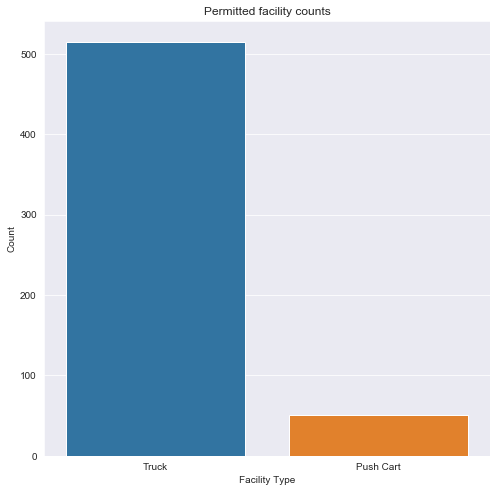

In [10]:
sns.countplot('FacilityType', data=sf)
plt.xlabel('Facility Type')
plt.ylabel('Count')
plt.title('Permitted facility counts')

We want a further breakdown of the data to see who is apply for permits and how many are they applying for. We do this by aggregating the data, counting the number of occurrences a Applicant appears in the dataset.

In [11]:
sf_app = sf.groupby(['Applicant']).size().to_frame('Count')

sf_app.index.name = 'Applicant'
sf_app.reset_index(inplace=True)
sf_app.sort_values(by=['Count'], inplace=True)

sf_app_breakdown returns the frequency of a number of permits. This gives us an idea of how common it is to have a Applicant to have X number of locations.

In [12]:
sf_app_breakdown = sf_app.groupby('Count').count()

sf_app_breakdown['Percentage'] = sf_app_breakdown['Applicant']/sf_app_breakdown['Applicant'].sum()

A visualization of the sf_app_breakdown variable.

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



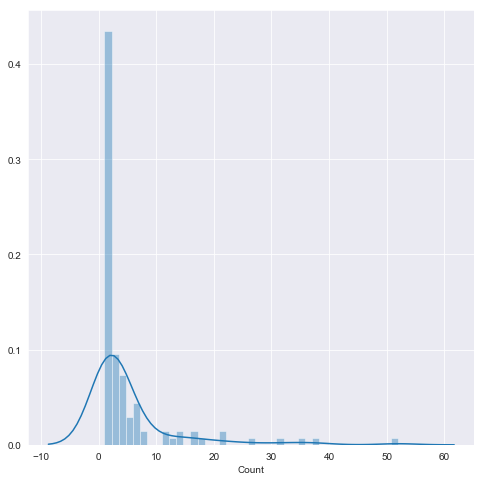

In [13]:
sns.distplot(sf_app['Count'])

A barplot of the number of permits per applicant is displayed below. Because we removed duplicates, this graph also shows the number of locations per applicant. 32% of applicants only have one location and 86% of applicants have less than 10 locations. The top 10 applicants hold 48% of the permits. The applicant with the most permits, May Catering, holds 9% of all permits with 52 total permits.

Text(0.5, 1.0, 'Permits per applicant')

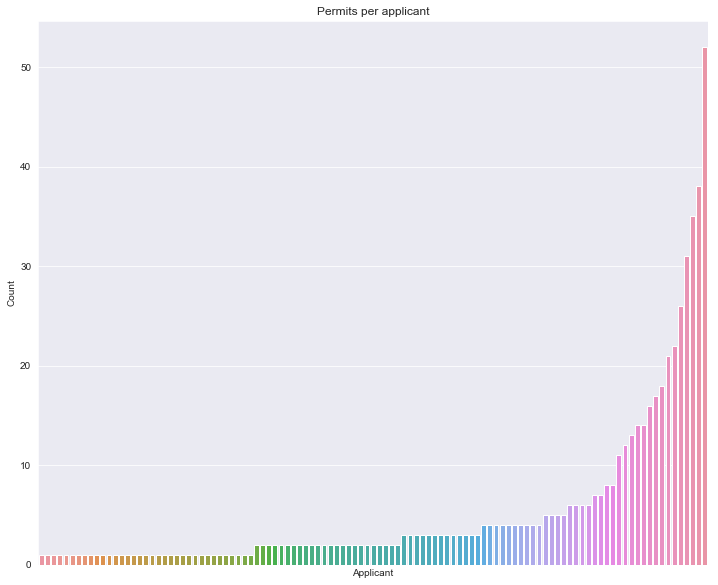

In [14]:
plt.figure(figsize=(12,10))

sns.barplot('Applicant', 'Count', data=sf_app)

plt.xticks([])
plt.xlabel('Applicant')
plt.ylabel('Count')

plt.title('Permits per applicant')

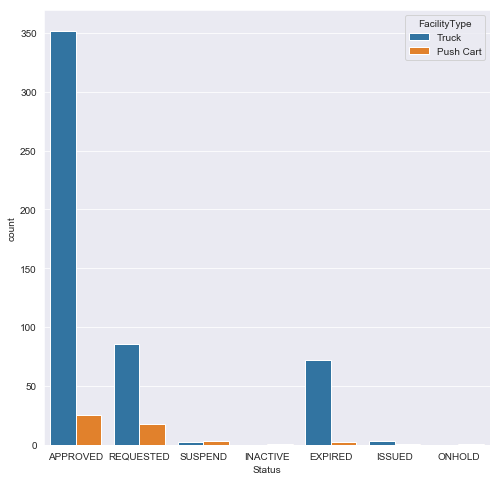

In [16]:
plt.figure(figsize=(8,8))
sns.countplot('Status', hue='FacilityType', data=sf)

Preforming a binomial test to see if the proportions below reflect the sample proportions.

In [65]:
facility_counts = sf.groupby('FacilityType').size()
push = facility_counts.iloc[0]/len(sf)
truck = facility_counts.iloc[1]/len(sf)

xtab = pd.crosstab(sf.FacilityType, sf.Status)
approved = xtab.iloc[0][0] + xtab.iloc[1][0]

We preformed a two-sided binomial test to test if the proportions of each status reflect the proportion in the dataset. We'll use the default $\alpha$ value of 0.05 as the significance level. Because the our p-value is less than our significance level we'll reject our $H_{0}$. That is, the number of approved permits for food trucks differs significantly from the expected value. 

In [94]:
stats.binom_test(xtab.iloc[1][0], n=approved, p=truck)

0.011714288484693375

In [129]:
sf['PriorPermit'].value_counts()

1    425
0    151
Name: PriorPermit, dtype: int64

151 of the applications have not had a prior permit while the remaining 425 applications have had only 1 prior permit.

Text(0.5, 1.0, 'Count of prior permits')

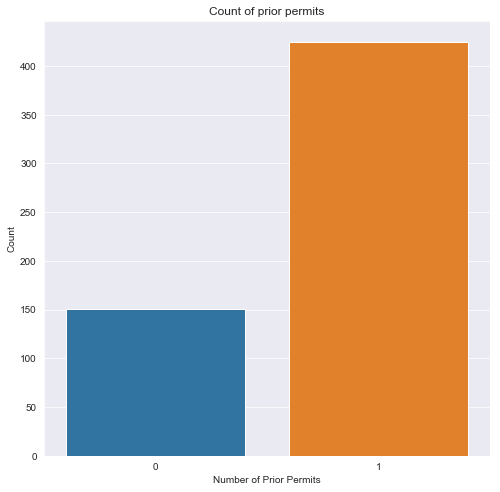

In [132]:
plt.figure(figsize=(8,8))
sns.countplot('PriorPermit', data=sf)

plt.xlabel('Number of Prior Permits')
plt.ylabel('Count')
plt.title('Count of prior permits')

Get the food items, facilitytype of the 10 most numerous food places

In [100]:
top_10 = sf_app.tail(10)

top_10_crossed = pd.merge(top_10, sf, on='Applicant')

Text(0.5, 1.0, 'Facility types for the top 10 applicants')

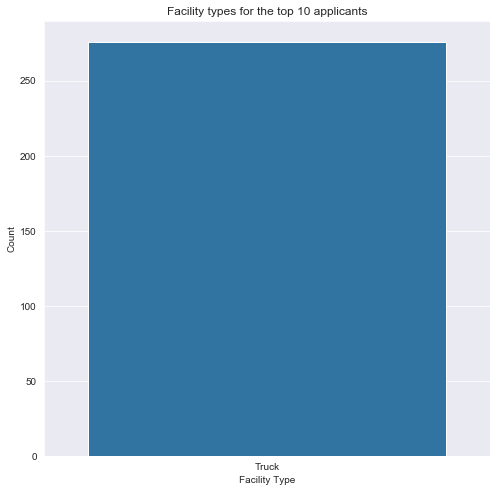

In [101]:
sns.countplot('FacilityType', data=top_10_crossed)

plt.xlabel('Facility Type')
plt.ylabel('Count')
plt.title('Facility types for the top 10 applicants')

In [114]:
top_10_crossed['FoodItems'].unique()

array(['Cold Truck: Pre-packaged sandwiches: Chicken Bake: Canned Soup: Chili Dog: Corn Dog: Cup of Noodles: Egg Muffins: Hamburgers: Cheeseburgers: Hot Dog: Hot sandwiches: quesadillas: Beverages: Flan: Fruits: Yogurt: Candy: Cookies: Chips: Donuts: Snacks',
       'COLD TRUCK. Deli: bbq chicken skewer: Chinese spring roll: Chinese fried rice/noodle: fried chicken leg/wing: bbq chicken sandwich: chicken cheese burger: burrito: lumpia. Snack: sunflower seeds: muffins: chips: snickers: kit-kat: 10 types of chocolate. Drinks: Coke: 7-Up: Dr. Pepper: Pepsi: Redbull: Vitamin Water: Rockstar: Coconut Juice: Water. Hot drinks: coffee: tea.',
       'Cold Truck: Soda:Chips:Candy: Cold/Hot Sandwiches: Donuts.  (Pitco Wholesale)',
       'Ice Cream: Pre-Packaged Chips: Candies: Bottled Water & Canned SODA',
       'Cold Truck: Hamburger: cheeseburgers: hot dogs: hot sandwiches: cold sandwiches: egg muffins: cup of noodles: corn dogs: canned soup: coffee: hot cocoa: hot tea: gatorade: juice: mil

### Citations

1. Butler, Stephanie. “From Chuck Wagons to Pushcarts: The History of the Food Truck.” History.com, A&E Television Networks, 8 Aug. 2014, www.history.com/news/from-chuck-wagons-to-pushcarts-the-history-of-the-food-truck.
2. Mobile Cuisine, LLC. “The Complete History of American Food Trucks.” Mobile Cuisine | Food Truck, Pop Up & Street Food Coverage, 31 Mar. 2017, mobile-cuisine.com/business/history-of-american-food-trucks/.

### Images
1. https://www.visitmuskogee.com/calendar/food-truck-wars-2/